# CNN_Plant_Seedling_Classification


此範例會使用模組化的軟體設計方法，它將一個大型的程式或專案拆分成更小、更容易管理的模塊或組件。每個模塊執行特定的功能或處理特定的任務，並且可以獨立開發、測試和維護。這樣的設計有助於提高程式碼的可讀性、可重用性和可維護性，並且讓不同團隊的開發者能夠協作更輕鬆。在PyTorch中，模組化通常表現為創建獨立的模型、函數和類別，每個模塊負責特定的任務，並且可以輕鬆組合在一起以構建更大的深度學習模型。

本次課程將會把pytorch訓練流程分成以下幾個模組來教學:
1. `Dataset`
2. `Dataloader`
3. `Model`
4. `Train` Function
5. `Valid` Function
6. `Plot Curve` Function
7. `Predict` Function
8. `Main` Function
9. `Addition` Customize model

## Download Datasets

此範例使用kaggle上的[Plant Seedlings Classification](https://www.kaggle.com/c/plant-seedlings-classification)資料集，請先至網站中下載`plant-seedlings-classification.zip`，透過`google.colab`套件，我們可以讓 Colab 上的程式直接讀取自己的雲端硬碟。


執行下面的code之前，請先確保自己的google drive中已經有`plant-seedlings-classification.zip`檔案，並確保檔案位置正確。

掛載自己的google drive後，雲端硬碟的根目錄為: `/content/gdrive/MyDrive/`



In [1]:
import os
import zipfile
from google.colab import drive

drive.mount('/content/gdrive')
data_dir = '/content/gdrive/MyDrive/Colab_Notebooks/plant_seedlings_classification/' # dataset's dir you want to unzip

if not os.path.exists(data_dir):
  zip_dir = '/content/gdrive/MyDrive/Colab_Notebooks/plant-seedlings-classification.zip' # your zip file's dir

  with zipfile.ZipFile(zip_dir, 'r') as zip_ref:
      zip_ref.extractall(data_dir)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Import Package

In [2]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

from torchvision import models
from torchvision.utils import make_grid
from torchvision import transforms as tsfm
from torchvision.datasets import ImageFolder

import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
from pathlib import Path
from IPython import display

# Set random seed for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.backends.cudnn.deterministic = True

## Config
Config of Hyperparameter

In [4]:
# Set Hyperparameters
batch_size = 64
epochs = 5
learning_rate = 0.001
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

## 1. Custom Pytorch Dataset


A `Dataset` in Pytorch should have three methods:

1. `__init__`: Read data & preprocess
2. `__len__`: return a integer indicating the size of the dataset
3. `__getitem__`: given an index `idx`, return the `idx`-th sample

In our case, the download data is structured as:
```
├── train
│   ├── Black-grass (Class name)
│   │   ├── 0050f38b3.png
│   │   ├── 0183fdf68.png
│   │   ├── 0260cffa8.png
│   │   ├── ...
│   └── Charlock
│   │   ├── 022179d65.png
│   │   ├── 02c95e601.png
│   │   ├── 04098447d.png
│   │   ├── ...
│   └── ...
├── test
│   ├── 0021e90e4.png
│   ├── 003d61042.png
│   ├── 007b3da8b.png
│   ├── ...
```

We can simply find all the pngs and load them into memory when needed. In common practice, dataset will receive one or more `torchvision.transforms` which transform the png (loaded as `PIL.Image`) into pytorch tensor.

`Dataloader` batchify the samples in dataset, i.e. builds mini-batch from the data return by dataset's `__getitem__` . We then iterate the `Dataloader` for training.

Usually `Dataloader` is finite and will run of mini-batches when we have seen all samples in `Dataset` once. However, to write our code easily, we can create an infinite `Sampler` that can guide the batchification process in `Dataloader` and make `Dataloader` supply mini-batches infinitely.

In [5]:
class Train_data(Dataset):
    def __init__(self, root_dir, transform=None):
        self.data = ImageFolder(root=root_dir, transform=transform)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        return img, label

class Pred_data(Dataset):
    def __init__(self, root_dir, transform=None):
        self.img_paths = list(Path(root_dir).glob('*.png'))
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx])
        img = self.transform(img)
        img = img.unsqueeze(0)
        return img

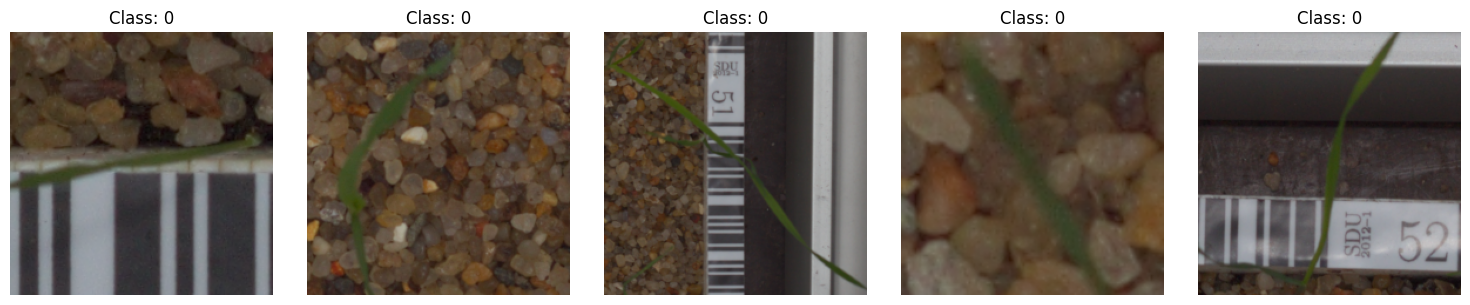

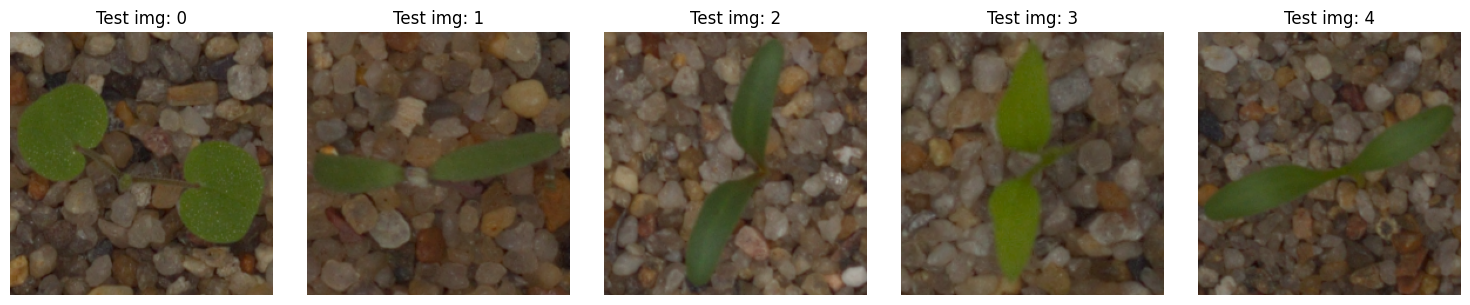

In [6]:
# visualize dataset item for debug
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
transform = tsfm.Compose([
    tsfm.Resize((224, 224)),
    tsfm.ToTensor(),
])

whole_set = Train_data(
    root_dir=train_dir,
    transform=transform
)

test_set = Pred_data(
    root_dir=test_dir,
    transform=transform
)

num_images_to_display = 5
fig, axs = plt.subplots(1, num_images_to_display, figsize=(15, 3))

for i, (img, label) in enumerate(whole_set):
    axs[i].imshow(img.permute(1, 2, 0))
    axs[i].set_title(f'Class: {label}')
    axs[i].axis('off')

    num_images_to_display -= 1
    if num_images_to_display == 0:
        break

plt.tight_layout()
plt.show()

num_images_to_display = 5
fig, axs = plt.subplots(1, num_images_to_display, figsize=(15, 3))
for i, img in enumerate(test_set):
    axs[i].imshow(img[0].permute(1, 2, 0))
    axs[i].set_title(f'Test img: {i}')
    axs[i].axis('off')

    num_images_to_display -= 1
    if num_images_to_display == 0:
        break

plt.tight_layout()
plt.show()

## 2. Split train, valid set and Create Dataloader:


In [7]:
train_set, valid_set = random_split(whole_set, [0.8, 0.2])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size)

## 3. Create Model

A `nn.Module` in Pytorch should have two methods:

1. `__init__`: Initialize your model & define layers
2. `forward`: Compute output of your Model



In [8]:
class resnet_50(nn.Module):
    def __init__(self, num_classes = 12):
        super(resnet_50, self).__init__()
        # pytorch built-in models
        self.resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        # set model layers trainable
        for param in self.resnet50.parameters():
            param.requires_grad = True

        # redifine/customize last classification layer
        self.resnet50.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.resnet50(x)
        return x

In [9]:
# test model for debug

model = resnet_50(num_classes=12)
# print(model)
x = torch.rand(1, 3, 224, 224)
y = model(x)
print(x)
print(y)

tensor([[[[0.6671, 0.7646, 0.2732,  ..., 0.2299, 0.8501, 0.7446],
          [0.3145, 0.1770, 0.4947,  ..., 0.2657, 0.5151, 0.2777],
          [0.9626, 0.3276, 0.1024,  ..., 0.8075, 0.6732, 0.5020],
          ...,
          [0.1053, 0.0563, 0.9618,  ..., 0.0177, 0.8644, 0.9249],
          [0.2369, 0.6065, 0.7551,  ..., 0.8097, 0.0856, 0.5755],
          [0.6274, 0.9982, 0.7637,  ..., 0.2613, 0.3500, 0.0402]],

         [[0.5232, 0.1650, 0.3030,  ..., 0.7249, 0.3848, 0.7339],
          [0.5719, 0.4828, 0.7574,  ..., 0.5348, 0.9477, 0.0841],
          [0.2502, 0.2524, 0.9801,  ..., 0.1184, 0.5851, 0.6820],
          ...,
          [0.9749, 0.6790, 0.7742,  ..., 0.9642, 0.1267, 0.7451],
          [0.0856, 0.5820, 0.4309,  ..., 0.6179, 0.5303, 0.8151],
          [0.7269, 0.7204, 0.1821,  ..., 0.2500, 0.2649, 0.3273]],

         [[0.0077, 0.6897, 0.1437,  ..., 0.5420, 0.3801, 0.0750],
          [0.3946, 0.1692, 0.3127,  ..., 0.4402, 0.9574, 0.0358],
          [0.8982, 0.4166, 0.9354,  ..., 0

## 4. Define Train Function(for one epoch):


In [10]:
def train(model, criterion, optimizer, train_loader, epoch, total_epochs, batch_size):
    model.train()
    train_loss, train_acc = [], []

    tqdm_iter = tqdm(train_loader, desc="Epoch: {}/{} ({}%) | Training loss: NaN".format(
    epoch, total_epochs, int(epoch/total_epochs * 100)), leave=False)
    epoch_loss, epoch_acc = 0.0, 0.0
    for batch_idx, (data, label) in enumerate(tqdm_iter):
        data, target = data, label
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == target).float().mean().item()
        epoch_loss += loss.item()
        epoch_acc += acc

        tqdm_iter.set_description("Epoch: {}/{} ({}%) | Training loss: {:.6f} | Training Acc: {:.6f}".format(
        epoch + 1, total_epochs, int((epoch+1)/total_epochs * 100), round(loss.item(), 6), round(acc, 6)))

    return epoch_loss / len(train_loader), epoch_acc / len(train_loader)

In [11]:
# debug "train" function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

loss, acc = train(
    model,
    criterion,
    optimizer,
    train_loader,
    epoch=1,
    total_epochs=1,
    batch_size=batch_size
)

print(loss, acc)

Epoch: 1/1 (100%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

1.838727557659149 0.39479166666666665


## 5. Define Valid Function(for one epoch):


In [12]:
def valid(model, criterion, valid_loader, epoch, total_epochs, batch_size):
    model.eval()

    tqdm_iter = tqdm(valid_loader, desc="Epoch: {}/{} ({}%) | Valid loss: NaN".format(
    epoch, total_epochs, int(epoch/total_epochs * 100)), leave=False)
    epoch_loss, epoch_acc = 0.0, 0.0
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(tqdm_iter):
            data, target = data, label
            output = model(data)
            loss = criterion(output, target)
            acc = (output.argmax(dim=1) == target).float().mean().item()
            epoch_loss += loss.item()
            epoch_acc += acc

            tqdm_iter.set_description("Epoch: {}/{} ({}%) | Valid loss: {:.6f} | Valid Acc: {:.6f}".format(
            epoch + 1, total_epochs, int((epoch+1)/total_epochs * 100), round(loss.item(), 6), round(acc, 6)))

    return epoch_loss / len(valid_loader), epoch_acc / len(valid_loader)

In [13]:
# debug "valid" function
criterion = nn.CrossEntropyLoss()
loss, acc = valid(
    model,
    criterion,
    valid_loader,
    epoch=1,
    total_epochs=1,
    batch_size=batch_size
)

print(loss, acc)

Epoch: 1/1 (100%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

5.587511984507243 0.2093364199002584


## 6. Plot Learning Curve Function:

In [14]:
def Plot(title, ylabel, epochs, train_loss, valid_loss):
    plt.figure()
    plt.title(title)
    plt.xlabel('epochs')
    plt.ylabel(ylabel)
    plt.plot(epochs, train_loss)
    plt.plot(epochs, valid_loss)
    plt.legend(['train', 'valid'], loc='upper left')

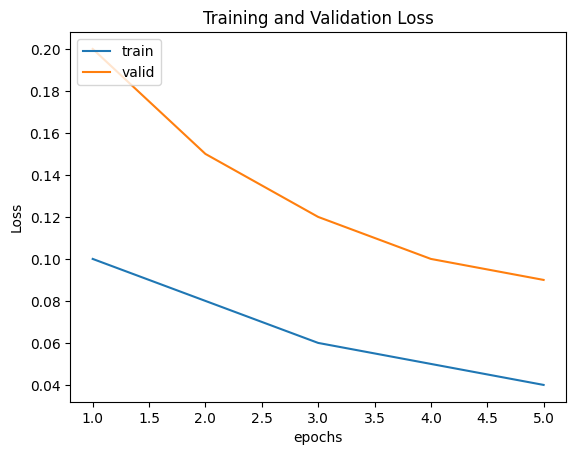

In [15]:
# debug "Plot" function
debug_epochs = [1, 2, 3, 4, 5]
debug_train_loss = [0.1, 0.08, 0.06, 0.05, 0.04]
debug_valid_loss = [0.2, 0.15, 0.12, 0.1, 0.09]

Plot("Training and Validation Loss", 'Loss', debug_epochs, debug_train_loss, debug_valid_loss)

plt.show()

## 7. Predict Function:

In [16]:
def predict(loader, model):
    model.eval()
    preds = []
    for data in tqdm(loader):
        pred = model(data)
        cls = torch.argmax(pred, dim=1)
        preds.append(cls)

    return preds

In [17]:
# Visualize Predict result
def view_pred_result(preds, num_images_to_display=5):
    labels = ['Black-grass', 'Charlock' , 'Cleavers' , 'Common Chickweed' , 'Common wheat' , 'Fat Hen' , 'Loose Silky-bent' , 'Maize' , 'Scentless Mayweed' , 'Shepherds Purse', 'Small-flowered Cranesbill' , 'Sugar beet']
    fig, axs = plt.subplots(1, num_images_to_display, figsize=(15, 3))
    for i, img in enumerate(test_set):
        axs[i].imshow(img[0].permute(1, 2, 0))
        axs[i].set_title(labels[preds[i].item()])
        axs[i].axis('off')

        num_images_to_display -= 1
        if num_images_to_display == 0:
            break

    plt.tight_layout()
    plt.show()

  0%|          | 0/794 [00:00<?, ?it/s]

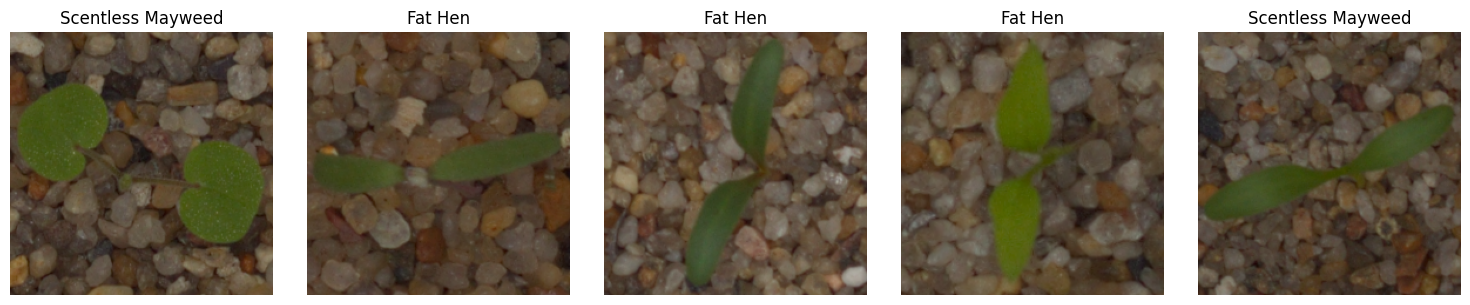

In [18]:
# debug "Predict" function & "View_Predict_result" function
test_dir = os.path.join(data_dir, 'test')
transform = tsfm.Compose([
    tsfm.Resize((224, 224)),
    tsfm.ToTensor(),
])
test_set = Pred_data(
    root_dir=test_dir,
    transform=transform
)
model = resnet_50(num_classes=12)

preds = predict(test_set, model)
view_pred_result(preds)

## 8. Main Function(training pipeline):
1. `Set Hyperparameters`: `batct_size`, `learning rate`, `epochs`...
2. `Initial`: initial `dataset`, `dataloader`, `model`
3. `Train`: Do train
4. `Valid`: Do valid
5. repeat `3.`  `4.` epochs times
6. `Plot curve`: Plot learning curve to observe the learning progress
7. `Predict`: Use the trained model to predict the results of the test set

5


Epoch: 0/5 (0%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.7267781431476276, Avg train acc: 0.765451388557752


Epoch: 0/5 (0%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.9755465825398763, Avg valid acc: 0.7560185194015503


Epoch: 1/5 (20%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.27211015472809474, Avg train acc: 0.9036458333333334


Epoch: 1/5 (20%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.6096243659655253, Avg valid acc: 0.8057098746299743


Epoch: 2/5 (40%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.20862557149181762, Avg train acc: 0.9338541666666667


Epoch: 2/5 (40%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.2326259930928548, Avg valid acc: 0.9150462945302328


Epoch: 3/5 (60%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.11526041347533464, Avg train acc: 0.9621527781089146


Epoch: 3/5 (60%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.22422422816356022, Avg valid acc: 0.9354938268661499


Epoch: 4/5 (80%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.09181928196921944, Avg train acc: 0.9713541666666666


Epoch: 4/5 (80%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.2558710306882858, Avg valid acc: 0.9302854935328165


  0%|          | 0/794 [00:00<?, ?it/s]

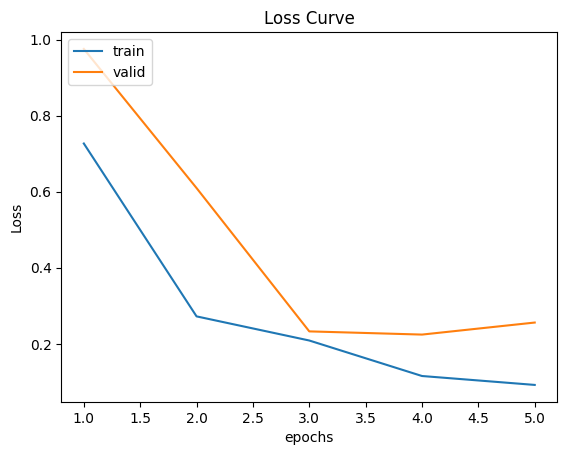

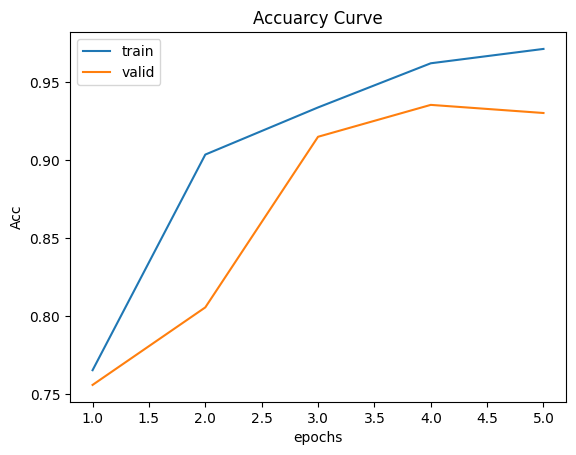

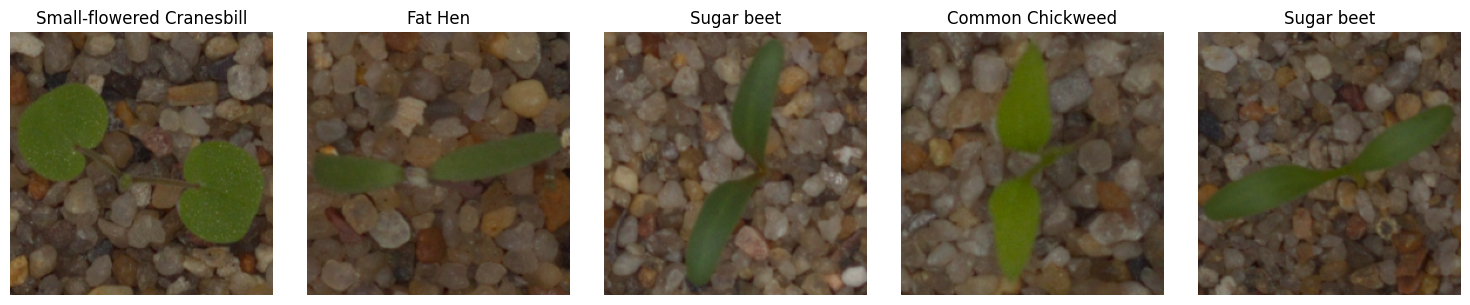

In [19]:
def main():
    # initial transform
    transform = tsfm.Compose([
        tsfm.Resize((224, 224)),
        tsfm.ToTensor(),
    ])

    # initial dataset
    whole_set = Train_data(
        root_dir=train_dir,
        transform=transform
    )

    test_set = Pred_data(
        root_dir=test_dir,
        transform=transform
    )

    # split train valid and initial dataloader
    train_set_size = int(len(whole_set) * 0.8)
    valid_set_size = len(whole_set) - train_set_size
    train_set, valid_set = random_split(whole_set, [train_set_size, valid_set_size])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size)

    # initial model
    model = resnet_50(num_classes=12)

    # initial loss_function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # initial plot values
    train_loss, train_acc = [], []
    valid_loss, valid_acc = [], []
    epoch_list = []

    # repeat train and valid epochs times
    print(epochs)
    for epoch in range(epochs):
      epoch_list.append(epoch + 1)

      loss, acc = train(
          model,
          criterion,
          optimizer,
          train_loader,
          epoch=epoch,
          total_epochs=epochs,
          batch_size=batch_size
      )
      train_loss.append(loss)
      train_acc.append(acc)
      print(f'Avg train Loss: {loss}, Avg train acc: {acc}')

      loss, acc = valid(
          model,
          criterion,
          valid_loader,
          epoch=epoch,
          total_epochs=epochs,
          batch_size=batch_size
      )
      valid_loss.append(loss)
      valid_acc.append(acc)
      print(f'Avg valid Loss: {loss}, Avg valid acc: {acc}')

    Plot("Loss Curve", 'Loss', epoch_list, train_loss, valid_loss)
    Plot("Accuarcy Curve", 'Acc', epoch_list, train_acc, valid_acc)

    preds = predict(test_set, model)
    view_pred_result(preds)

main()

## 9. Addition: Customize your own model
Create your own deep learning model, by define the inner layers in hand-craft<br>
Example for VGG16 model: https://arxiv.org/abs/1409.1556

In [20]:
class VGG16(nn.Module):
    def __init__(self, num_classes=12):
        super(VGG16, self).__init__()
        # input layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())

        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        #  classifier
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU()
        )

        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU()
        )

        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [21]:
# Test model to debug
x = torch.rand(1, 3, 224, 224)
model = VGG16(num_classes=12)
y = model(x)
print(y)

tensor([[-0.2545, -0.0814,  0.5247, -0.0274,  0.4320, -0.0390,  0.0395, -0.2929,
         -0.0466, -0.0138, -0.0125,  0.0657]], grad_fn=<AddmmBackward0>)


Rerun training for VGG16 model

In [ ]:
def main():
    # initial transform
    transform = tsfm.Compose([
        tsfm.Resize((224, 224)),
        tsfm.ToTensor(),
    ])

    # initial dataset
    whole_set = Train_data(
        root_dir=train_dir,
        transform=transform
    )

    test_set = Pred_data(
        root_dir=test_dir,
        transform=transform
    )

    # split train valid and initial dataloader
    train_set_size = int(len(whole_set) * 0.8)
    valid_set_size = len(whole_set) - train_set_size
    train_set, valid_set = random_split(whole_set, [train_set_size, valid_set_size])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size)

    # initial model
    model = VGG16(num_classes=12)

    # initial loss_function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # initial plot values
    train_loss, train_acc = [], []
    valid_loss, valid_acc = [], []
    epoch_list = []

    # repeat train and valid epochs times
    print(epochs)
    for epoch in range(epochs):
      epoch_list.append(epoch + 1)

      loss, acc = train(
          model,
          criterion,
          optimizer,
          train_loader,
          epoch=epoch,
          total_epochs=epochs,
          batch_size=batch_size
      )
      train_loss.append(loss)
      train_acc.append(acc)
      print(f'Avg train Loss: {loss}, Avg train acc: {acc}')

      loss, acc = valid(
          model,
          criterion,
          valid_loader,
          epoch=epoch,
          total_epochs=epochs,
          batch_size=batch_size
      )
      valid_loss.append(loss)
      valid_acc.append(acc)
      print(f'Avg valid Loss: {loss}, Avg valid acc: {acc}')

    Plot("Loss Curve", 'Loss', epoch_list, train_loss, valid_loss)
    Plot("Accuarcy Curve", 'Acc', epoch_list, train_acc, valid_acc)

    preds = predict(test_set, model)
    view_pred_result(preds)

main()

5


Epoch: 0/5 (0%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]